# Исследование надёжности заёмщиков
Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию.

In [73]:
#Импорт библиотеки и вывод датасета
import pandas as pd
df = pd.read_csv('/datasets/data.csv')
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


Проверим, что означают столбцы с идентификаторами

In [74]:
df['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [75]:
df['family_status_id'].value_counts()

0    12380
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64

### Вывод

Идентификаторы соответствую той или иной категориальной переменной. В датасете присутствуют отрицательные значения возраста, часть значений указана по-разному, наприер, "среднее" и "СРЕДНЕЕ" образование. В таблице более 20 тычсяч строк, надо проверить данные на пропуски, дубликаты, лемматизировать. Сконцентрируемся на обработки столбцов, касающихся семейного положения, наличия детей, дохода и цели кредита, ведь именно несут в себе отвепты на поставленные вопросы.

## Шаг 2. Предобработка данных

### Обработка пропусков

In [76]:
#Проверим наличие пропусков в "Семейном положении"
df['family_status'].isna().mean()

0.0

Пропуски в "Семейном положении" не обнаружены

In [77]:
#Проверим наличие пропусков в "Целях получения кредитов"
df['purpose'].isna().mean()

0.0

Пропуски в "Семейном положении" не обнаружены

In [78]:
#Проверим наличие пропусков в "Количестве детей"
df['children'].isna().mean()

0.0

In [79]:
#Посмотрим, какие значения спрятаны в "Количестве детей"
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Значение "-1" скорее всего появилось в результате превращения тире в минус, а "20" в результате опечаток.
Предположим, что у данных клиентов банка есть дети и введем столбец "children_id", где "0" будет соответствовать клиентам без детей, а "1" клиентам с детьми

In [80]:
df['children_id'] = '1'
df.loc[df['children'] == 0, 'children_id'] = '0'

In [81]:
#Проверим наличие пропусков в "Наличии кредитов"
df['debt'].isna().mean()

0.0

In [82]:
#Посмотрим, какие значения спрятаны в "Наличии кредитов"
df['debt'].value_counts()

0    19784
1     1741
Name: debt, dtype: int64

In [83]:
#Проверим наличие пропусков в "Доходы"
df['total_income'].isna().mean()

0.10099883855981417

В столбце "Доходы" примерно 10% пропусков. Сделаем дополнительный столбец с помощью функции isnull, и вместо пропусков подставим средние значения заработков по типу занятости

In [84]:
df['total_income_check'] = df['total_income'].isnull()

In [85]:
#Посмотрим типы занятости
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

In [86]:
total_income_sotrudnic = df.loc[df['income_type'] == 'сотрудник', 'total_income'].mean()
total_income_kompanyon = df.loc[df['income_type'] == 'компаньон', 'total_income'].mean()
total_income_old = df.loc[df['income_type'] == 'пенсионер', 'total_income'].mean()
total_income_government = df.loc[df['income_type'] == 'госслужащий', 'total_income'].mean()

In [87]:
df.loc[(df['total_income_check'] == True) & (df['income_type'] == 'сотрудник'), 'total_income'] = total_income_sotrudnic
df.loc[(df['total_income_check'] == True) & (df['income_type'] == 'компаньон'), 'total_income'] = total_income_kompanyon
df.loc[(df['total_income_check'] == True) & (df['income_type'] == 'пенсионер'), 'total_income'] = total_income_old
df.loc[(df['total_income_check'] == True) & (df['income_type'] == 'госслужащий'), 'total_income'] =total_income_government

In [88]:
#Проверим наличие пропусков в "Доходы"
df['total_income'].isna().mean()

4.645760743321719e-05

В столбце доходов все еще имеются пропуски, проверим их

In [89]:
df['total_income_check'] = df['total_income'].isnull()
df.loc[df['total_income_check'] == True ,:]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_id,total_income_check
5936,0,NaN,58,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости,0,True


Остается один предриниматель с отсутствием данных по доходу. Так как в датасете их всего два, подставить заработк дркгого предпринимателя будет некорректно, так как выборка слишком мала. Учитывая, что выводы о зависимости наличия долгов по кредитам от типа занятости не требуются, удалим данную строку.

In [90]:
df.drop(df[df['total_income_check'] == True].index, inplace=True)

In [91]:
#Проверим результаты удаления
df['total_income'].isna().mean()

0.0

Теперь в графе доходы нет пропусков

### Вывод

Все необходимые для исследования строки были проверены на наличие пропусков. У 10% клиентов не был указан доход, поэтому были высчитаны средние доходы по их профессиям. Одна строка была удалена, так как было недостаточно данных для подсчета среднего дохода для предпринимателей.

## Замена типа данных

In [92]:
#Посмотрим типы данных столбцов
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 14 columns):
children              21524 non-null int64
days_employed         19351 non-null float64
dob_years             21524 non-null int64
education             21524 non-null object
education_id          21524 non-null int64
family_status         21524 non-null object
family_status_id      21524 non-null int64
gender                21524 non-null object
income_type           21524 non-null object
debt                  21524 non-null int64
total_income          21524 non-null float64
purpose               21524 non-null object
children_id           21524 non-null object
total_income_check    21524 non-null bool
dtypes: bool(1), float64(2), int64(5), object(6)
memory usage: 2.3+ MB


In [93]:
# Для удобства поменяем тип данных в total_income на int
try:
    df['total_income'] = df['total_income'].astype('int')  
except:
        print('Ошибка при переводe')
 

In [94]:
#Посмотрим теперь типы данных столбца total_income
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 14 columns):
children              21524 non-null int64
days_employed         19351 non-null float64
dob_years             21524 non-null int64
education             21524 non-null object
education_id          21524 non-null int64
family_status         21524 non-null object
family_status_id      21524 non-null int64
gender                21524 non-null object
income_type           21524 non-null object
debt                  21524 non-null int64
total_income          21524 non-null int64
purpose               21524 non-null object
children_id           21524 non-null object
total_income_check    21524 non-null bool
dtypes: bool(1), float64(1), int64(6), object(6)
memory usage: 2.3+ MB


### Вывод

Тип данных в графе доходов был изменен на целочи сленный тип. Менять тип данных других столбцов нет необходимости.

## Обработка дубликатов

In [95]:
#Проверим датасет на наличие дубликатов
df.duplicated().sum()

54

Как видно, имеется 54 дублирующие строки. Удалим повторяющиеся значения

In [96]:
df = df.drop_duplicates()

In [97]:
#Сделаем контрольную проверку датасета на наличие дубликатов
df.duplicated().sum()

0

### Вывод

В имеющемся датасете были удалены дубликаты строк

## Лемматизация

In [106]:
#Изучим столбец "purpose"
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Имеется много объектов, имеющих схожий смысл, но по-разному записанные

In [110]:
from pymystem3 import Mystem
m = Mystem()
 
# выборка уникальных уникальных целей получения кредита
purpose_dict = df['purpose'].unique()
 
# создание пустого словаря лемм
lemmas_dict_temp = []
 
# лемматизация целей получения кредита
for purpose in purpose_dict:
    lemmas = m.lemmatize(purpose)
    for l in lemmas:
        lemmas_dict_temp.append(l)


In [111]:
#Изучим возможные цели кредита
lemmas_dict_temp

['покупка',
 ' ',
 'жилье',
 '\n',
 'приобретение',
 ' ',
 'автомобиль',
 '\n',
 'дополнительный',
 ' ',
 'образование',
 '\n',
 'сыграть',
 ' ',
 'свадьба',
 '\n',
 'операция',
 ' ',
 'с',
 ' ',
 'жилье',
 '\n',
 'образование',
 '\n',
 'на',
 ' ',
 'проведение',
 ' ',
 'свадьба',
 '\n',
 'покупка',
 ' ',
 'жилье',
 ' ',
 'для',
 ' ',
 'семья',
 '\n',
 'покупка',
 ' ',
 'недвижимость',
 '\n',
 'покупка',
 ' ',
 'коммерческий',
 ' ',
 'недвижимость',
 '\n',
 'покупка',
 ' ',
 'жилой',
 ' ',
 'недвижимость',
 '\n',
 'строительство',
 ' ',
 'собственный',
 ' ',
 'недвижимость',
 '\n',
 'недвижимость',
 '\n',
 'строительство',
 ' ',
 'недвижимость',
 '\n',
 'на',
 ' ',
 'покупка',
 ' ',
 'подержать',
 ' ',
 'автомобиль',
 '\n',
 'на',
 ' ',
 'покупка',
 ' ',
 'свой',
 ' ',
 'автомобиль',
 '\n',
 'операция',
 ' ',
 'с',
 ' ',
 'коммерческий',
 ' ',
 'недвижимость',
 '\n',
 'строительство',
 ' ',
 'жилой',
 ' ',
 'недвижимость',
 '\n',
 'жилье',
 '\n',
 'операция',
 ' ',
 'со',
 ' ',
 'свой'

In [127]:
# Сделаем функцию для будущей категоризации целей кредита
def class_purpose(data):
    data = m.lemmatize(data)
    if 'недвижимость' in data:
        return 'недвижимость'
    if 'жилье' in data:
        return 'недвижимость'
    if 'свадьба' in data:
        return 'свадьба'
    if 'автомобиль' in data:
        return 'автомобиль'
    if 'образование,'  in data:
        return 'образование'
    if  'образование' in data:
        return 'образование'
   
    return 'другое'

In [130]:
#Применим функцию к столбцу purpose
df['purpose_type'] = df['purpose'].apply(class_purpose)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [131]:
df['purpose_type'].value_counts()

недвижимость    10813
автомобиль       4308
образование      4014
свадьба          2335
Name: purpose_type, dtype: int64

### Вывод

Изначально был лемматизирован список всех уникальных значение причин взятия кредита. Далее были выделены наиболее частые категории взятия кредита: недвижимость, автомобиль, образование, свадьба. Цель кредита каждого клиента была определена с учетом этих категорий.

## Категоризация данных

In [103]:
# Сделаем класификацию по наличию детей
df.groupby('children_id')['debt'].agg(['count','mean'])

,count,mean
children_id,,
0,14106,0.075358
1,7364,0.092070


In [127]:
# Сделаем класификацию по заработку клиентов
def income_group(income):
     
        if income <= 50000:
                return 'низкий'
        if income <= 100000 and income >= 50001 :
                return 'средний'
        if income <= 160000 and income >= 100001 :
                return 'выше среднего'
        return 'высокий'

In [128]:
df['total_income_id'] = df['total_income'].apply(income_group)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [129]:
df.groupby('total_income_id')['debt'].agg(['count','mean'])

,count,mean
total_income_id,,
высокий,10663,0.076995
выше среднего,6633,0.088497
низкий,347,0.063401
средний,3827,0.081265


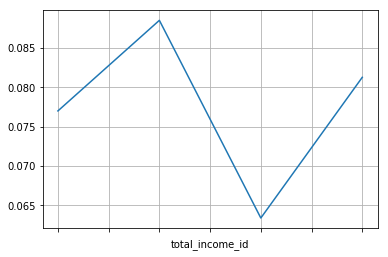

In [130]:
#Визуализируем классификацию
import matplotlib
df.groupby('total_income_id')['debt'].mean().plot(grid=True)

In [131]:
# Сделаем класификацию по семейному статусу
df['family_status'].value_counts()

женат / замужем          12343
гражданский брак          4163
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

In [132]:
df.groupby('family_status')['debt'].agg(['count','mean'])

,count,mean
family_status,,
Не женат / не замужем,2810,0.097509
в разводе,1195,0.071130
вдовец / вдова,959,0.065693
гражданский брак,4163,0.093202
женат / замужем,12343,0.075427


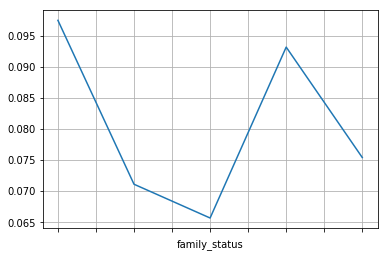

In [133]:
#Визуализируем классификацию
df.groupby('family_status')['debt'].mean().plot(grid=True)

In [132]:
# Сделаем класификацию по причине взятия кредита
df.groupby('purpose_type')['debt'].agg(['count','mean'])

,count,mean
purpose_type,,
автомобиль,4308,0.093547
недвижимость,10813,0.072320
образование,4014,0.092177
свадьба,2335,0.079657


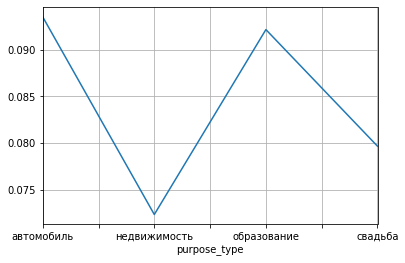

In [134]:
#Визуализируем классификацию
df.groupby('purpose_type')['debt'].mean().plot(grid=True)

### Вывод

Все данные были классифициремы по необходимым для исследования пераметрам

## Шаг 3. Ответьте на вопросы

1) Есть ли зависимость между наличием детей и возвратом кредита в срок?

### Вывод

Среди клиентов, неимеющих детей, примерно 7.5% должников.
Среди клиентов, имеющих детей, примерно 9.2% должников. Получается, что клиенты с детьми чаще имеют проблемы с возвратом кредитов.
Однако при этом выборка по бездетным клиентам была в 2 раза выше, поэтому нельзя однозначно утверждать о зависимости между наличием детей и возвратом кредита в срок.

2) Есть ли зависимость между семейным положением и возвратом кредита в срок?

### Вывод

Самыми ответственными клиентами банка оказались вдовцы/вдовы, а чаще взего задолжности имеют не женатые/не замужние клиенты (6.6% должников против 9.9%)

3) Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

### Вывод

Меньше всего должников среди клиентов с низкими доходами (6.3%), далее идут клиенты с высоким и средним доходами. Больше всегодолжников среди клиентов с доходом выше среднего (8.8%)

4) Как разные цели кредита влияют на его возврат в срок?

### Вывод

Меньше всего должников среди клиентов среди клиентов, которые берут кредит с целью операций с недвижимостью или на свадьбу (7.2% и 8.0% должников соответственно). Больше должников, среди клиентов, которые берут кредит с целью получения образования или на операции с автомобилем (9.2% и 9.4% должников соответственно).

## Шаг 4. Общий вывод

Все зависимости по категориям клиентов отличаются в среднем на 1-3%. Так, клиенты с низким доходом на 2.5% чаше возвращают кредит в срок, чем клиенты с доходом выше среднего.А среди не женатые/не замужние клиентов на 3.3% больше должников, чем среди вдовцов/вдов. Клиенты без детей на 1.7% чаше возвращают кредит в срок, чем клиенты с детьми. Среди клиентов, которые берут кредит на операции с недвижимостью, 7.2% должников, в тог время, как среди клиентов, покупающих автомобиль, должников больше на 2.2%